Importing Necessary Modules

In [2]:
import os
import time 
import uuid
import cv2

In [27]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 40

In [28]:
cap = cv2.VideoCapture(0)

for imgnum in range(number_images):
    print('Collection image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF==ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Collection image 0
Collection image 1
Collection image 2
Collection image 3
Collection image 4
Collection image 5
Collection image 6
Collection image 7
Collection image 8
Collection image 9
Collection image 10
Collection image 11
Collection image 12
Collection image 13
Collection image 14
Collection image 15
Collection image 16
Collection image 17
Collection image 18
Collection image 19
Collection image 20
Collection image 21
Collection image 22
Collection image 23
Collection image 24
Collection image 25
Collection image 26
Collection image 27
Collection image 28
Collection image 29
Collection image 30
Collection image 31
Collection image 32
Collection image 33
Collection image 34
Collection image 35
Collection image 36
Collection image 37
Collection image 38
Collection image 39


In [29]:
!labelme

'labelme' is not recognized as an internal or external command,
operable program or batch file.


Review Dataset And Build Image Loading Function

Importing TF And Other Dependencies

In [30]:
import json
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

Limit GPU Memory Growth

In [31]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.expermiental.set_memory_growth(gpu, True)

In [32]:
tf.config.list_physical_devices('GPU')

[]

Loading Image Into TF Date Pipeline

In [33]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle = False)

Checking If The Data/Images Are Loaded

In [34]:
images.as_numpy_iterator().next()

b'data\\images\\d69c29e3-578f-11ed-9b10-088fc30da5ad.jpg'

In [35]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.image.decode_jpeg(byte_img)
    print(img.shape)
    return img

In [36]:
images = images.map(load_image)

(None, None, None)


In [37]:
images.as_numpy_iterator().next()

array([[[135, 145, 120],
        [141, 147, 119],
        [149, 150, 116],
        ...,
        [148, 216, 237],
        [149, 217, 240],
        [151, 219, 242]],

       [[132, 141, 120],
        [136, 144, 120],
        [147, 148, 117],
        ...,
        [149, 217, 238],
        [150, 218, 241],
        [151, 219, 242]],

       [[125, 135, 124],
        [130, 138, 123],
        [140, 142, 121],
        ...,
        [150, 218, 241],
        [149, 216, 242],
        [150, 217, 243]],

       ...,

       [[ 93,  80,  46],
        [ 94,  81,  46],
        [ 95,  82,  47],
        ...,
        [ 78, 108, 110],
        [ 87, 112, 116],
        [ 91, 115, 117]],

       [[ 91,  80,  50],
        [ 90,  79,  47],
        [ 90,  79,  47],
        ...,
        [ 83, 112, 110],
        [ 86, 115, 113],
        [ 89, 115, 114]],

       [[ 88,  79,  50],
        [ 88,  79,  48],
        [ 88,  77,  47],
        ...,
        [ 85, 114, 112],
        [ 85, 114, 110],
        [ 84, 113, 109]]

In [38]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

Viewing Raw Images With Matplotlib

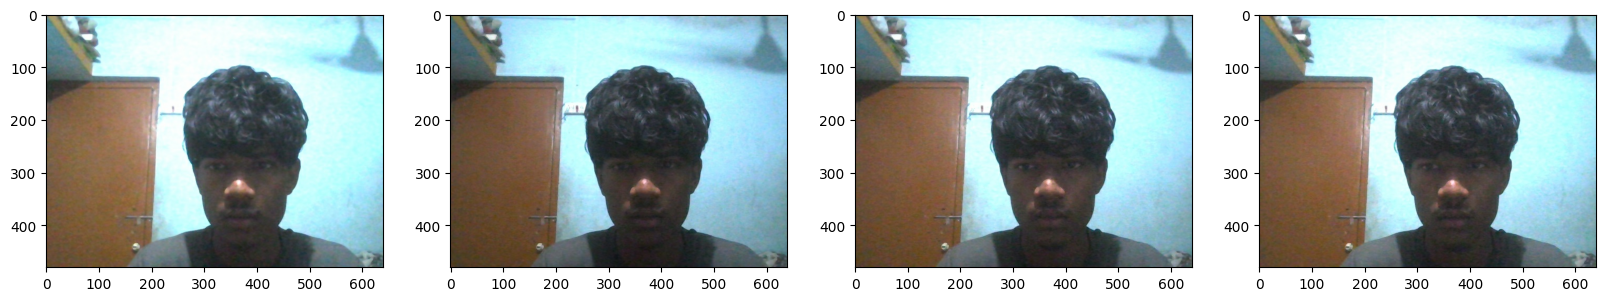

In [42]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)

plt.show()

Partition Unaugmented Data

Move The Mathcing Labels

In [46]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels')
            os.replace(existing_filepath, new_filepath)


PermissionError: [WinError 5] Access is denied: 'data\\labels\\d6efc0fc-578f-11ed-be4b-088fc30da5ad.json' -> 'data\\train\\labels'